# SVB surface test script

This script demonstrates SVB running 'on the surface' to infer the parameters of a single exponential decay signal model. 

Voxel-wise data is generated with a given amplitude, decay rate and noise SD. Each voxel in the volume is an independent time series of samples. Although they all share the same underlying signal parameters, the additive zero-mean (aka white) noise present in each one will be different. 

A spherical surface is then generated to intersect the voxel grid (note that many voxels will not intersect the surface and are therefore discarded). Multiple surface vertices may be present in each voxel, leading to an under-determined system. The SVB framework is used to infer the signal parameters at each vertex *on the surface* using the data generated in *volume space*. The process is run both with and without the spatial prior to illustrate how this is helpful in an under-determined system. 

In [1]:
%load_ext autoreload
%autoreload 2 
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import toblerone as tob 
import regtricks as rt
import trimesh
from svb.main import run

try:
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()
except ImportError:
    import tensorflow as tf

# To make tests repeatable
tf.set_random_seed(1)
np.random.seed(1)

Instructions for updating:
non-resource variables are not supported in the long term


Generate a cubic voxel grid of data. The signal parameters for the exponential model are amplitude and decay rate, and the noise is zero-mean with a given SD. Multiple samples are taken from the exponential curve to produce a 4D dataset (X,Y,Z,t)

In [2]:
# Set the properties of the simulated data
num_times = 200
sq_len = 5 
vox_size = 2 
true_params = {
    "amp1" : 10.0, # the true amplitude of the model
    "r1" : 3.0,    # the true decay rate
    "noise_sd" : 0.5,
}
true_var = true_params["noise_sd"]**2
dt = 5.0/(true_params["r1"] * num_times)
shape = (sq_len, sq_len, sq_len, num_times)
data = np.zeros(shape)

for t_idx in range(num_times):
    t = t_idx*dt
    data[..., t_idx] = true_params["amp1"]*math.exp(-true_params["r1"]*t)
data_noisy = data + np.random.normal(0, true_params["noise_sd"], size=shape)
print('Data shape', data_noisy.shape)

Data shape (5, 5, 5, 200)


Create a reference voxel grid for the data 


In [3]:
ref_spc = rt.ImageSpace.create_axis_aligned(np.zeros(3), 3 * [sq_len], 3 * [vox_size])
ref_spc

ImageSpace with properties:
size:          [   5.000    5.000    5.000], 
voxel size:    [   2.000    2.000    2.000], 
field of view: [  10.000   10.000   10.000],
vox2world:     [   2.000    0.000    0.000    1.000]
               [   0.000    2.000    0.000    1.000]
               [   0.000    0.000    2.000    1.000]
               [   0.000    0.000    0.000    1.000]
loaded from: (no direct file counterpart)

Generate a spherical surface, with radius slightly smaller than 1/2 the FoV of the reference space


In [4]:
sph_mesh = trimesh.creation.icosphere(2, ((sq_len * vox_size)/2.2))
surf = tob.Surface.manual(sph_mesh.vertices + (sq_len * vox_size)/2,    
                                sph_mesh.faces)
surf

Surface with 162 points and 320 triangles. 
min (X,Y,Z):  [0.45454547 0.45454547 0.45454547]
mean (X,Y,Z): [5.000001 5.       4.999999]
max (X,Y,Z):  [9.545455 9.545455 9.545455]

Form the weighting matrix for surface to volume projection. A weighted average is used (no PV correction etc)

In [5]:
surf2vol_weights = np.zeros((ref_spc.size.prod(), surf.points.shape[0]))
vertices_ijk = rt.aff_trans(ref_spc.world2vox, surf.points).round(0)
vertices_inds = np.ravel_multi_index(vertices_ijk.T.astype(np.int32), ref_spc.size)
for vtx_number, vtx_ind in enumerate(vertices_inds):
    surf2vol_weights[vtx_ind, vtx_number] = 1 

assert (surf2vol_weights.sum(0) == 1).all()
divisor = surf2vol_weights.sum(1)
surf2vol_weights[surf2vol_weights == 0] = -1
surf2vol_weights /= divisor[:,None]
surf2vol_weights[surf2vol_weights < 0] = 0
mask = (surf2vol_weights.sum(1) > 0)
surf2vol_weights = surf2vol_weights[mask,:]
assert (surf2vol_weights.sum(1) == 1).all()

vertices_per_voxel = (surf2vol_weights > 0).sum(1)

Plot the surface to volume projection matrix, calculate mean number of vertices per voxel (this illustrates the degree of under-determinacy)

Average number of vertices per voxel: 2.4545454545454546


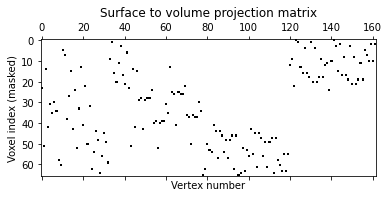

In [6]:
print('Average number of vertices per voxel:', vertices_per_voxel.mean())
plt.spy(surf2vol_weights)
plt.title('Surface to volume projection matrix')
plt.xlabel('Vertex number')
plt.ylabel('Voxel index (masked)')
plt.show()

Train model without covariance nor spatial prior

In [7]:
options = {
    "learning_rate" : 0.005,
    "batch_size" : 10,
    "sample_size" : 8,
    "epochs" : 200,
    "log_stream" : sys.stdout,
    "n2v" : surf2vol_weights,
    "prior_type": "N"
}

runtime, svb, training_history = run(
    data_noisy, "exp", 
    "example_out_cov", 
    mask=mask,
    surfaces={'LMS': surf}, 
    **options)

mean_cost_history = training_history["mean_cost"]
cost_history_v = training_history["voxel_cost"]
param_history_v = training_history["voxel_params"]
modelfit = svb.evaluate(svb.modelfit)
means = svb.evaluate(svb.model_means)
variances = svb.evaluate(svb.model_vars)


403, reconstr=145.649131) mean params=[6.913253   0.03077108 2.1886392 ] mean_var=[0.3147578  0.49636477 0.02379241] lr=0.005000, ss=8 - Saving
INFO :  - Epoch 0110: mean/median cost=149.290621/146.021584 (latent=6.234715, reconstr=143.055906) mean params=[6.891733   0.03045074 2.138032  ] mean_var=[0.31054503 0.48815432 0.02378167] lr=0.005000, ss=8 - Saving
INFO :  - Epoch 0111: mean/median cost=146.759663/139.966194 (latent=6.258915, reconstr=140.500749) mean params=[6.8818555 0.0305044 2.0898774] mean_var=[0.30662385 0.4802655  0.02378352] lr=0.005000, ss=8 - Saving
INFO :  - Epoch 0112: mean/median cost=144.342834/140.372907 (latent=6.283112, reconstr=138.059722) mean params=[6.934263   0.03014965 2.0323944 ] mean_var=[0.30238858 0.47200915 0.02377514] lr=0.005000, ss=8 - Saving
INFO :  - Epoch 0113: mean/median cost=141.568640/134.708486 (latent=6.308841, reconstr=135.259799) mean params=[7.0437584 0.0298052 1.9680136] mean_var=[0.2983716 0.4639114 0.0237546] lr=0.005000, ss=8 - 

For each parameter of interest, we infer a mean (best estimate) and variance (degree of uncertainty). We also project the surface parameter estimates back into volume space for reference. 

In [8]:
amp1_mean, r1_mean, noise_mean = [ svb.evaluate(svb.model_means)[d] for d in range(3) ]
amp1_var, r1_var, noise_var =  [ svb.evaluate(svb.model_vars)[0] for d in range(3) ] 
vol_amp1 = surf2vol_weights.dot(amp1_mean)

Plots: mean and variance of the amplitude and decay on the surface, as well as the volume projected mean amplitude and surface noise (SD or variance?). 

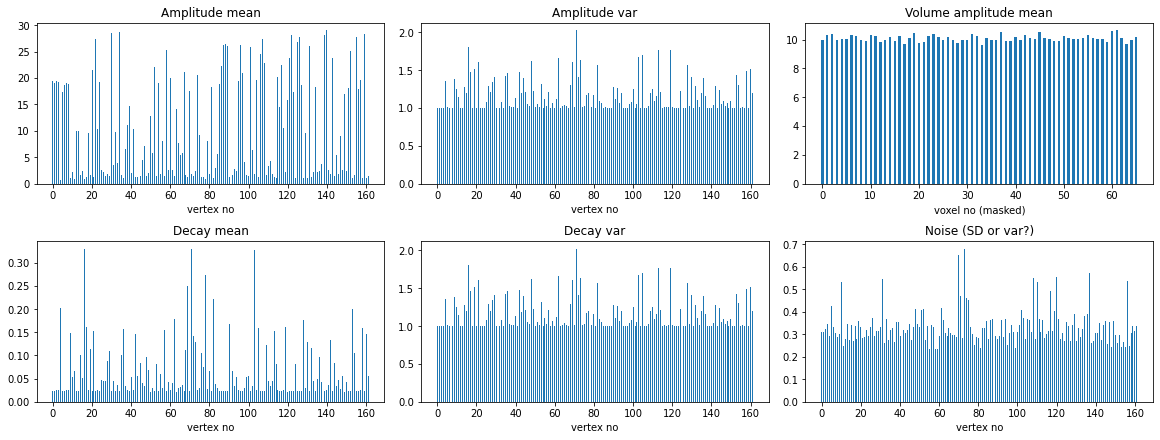

In [9]:
fig, axes = plt.subplots(2, 3, constrained_layout=True)
fig.set_size_inches(16,6)

axes[0,0].bar(np.arange(amp1_mean.size), amp1_mean, width=0.5)
axes[0,0].set_title('Amplitude mean')
axes[0,0].set_xlabel('vertex no')

axes[0,1].bar(np.arange(amp1_mean.size), amp1_var, width=0.5)
axes[0,1].set_title('Amplitude var')
axes[0,1].set_xlabel('vertex no')

axes[1,0].bar(np.arange(amp1_mean.size), r1_mean, width=0.5)
axes[1,0].set_title('Decay mean')
axes[1,0].set_xlabel('vertex no')

axes[1,1].bar(np.arange(amp1_mean.size), r1_var, width=0.5)
axes[1,1].set_title('Decay var')
axes[1,1].set_xlabel('vertex no')

axes[0,2].bar(np.arange(vol_amp1.size), vol_amp1, width=0.5)
axes[0,2].set_title('Volume amplitude mean')
axes[0,2].set_xlabel('voxel no (masked)')

axes[1,2].bar(np.arange(amp1_mean.size), noise_mean, width=0.5)
axes[1,2].set_title('Noise (SD or var?)')
axes[1,2].set_xlabel('vertex no')

plt.show()

Repeat the inference process, this time with the spatial prior enabled for amplitude and decay. This enforces similarity between the estimates of neighbouring vertices. 

In [10]:
options = {
    "learning_rate" : 0.005,
    "batch_size" : 10,
    "sample_size" : 8,
    "epochs" : 200,
    "log_stream" : sys.stdout,
    "n2v" : surf2vol_weights,
    "prior_type": "N",
    "param_overrides": {
        "amp1": { "prior_type": "M" }
    } 
}

runtime, svb, training_history = run(
    data_noisy, "exp", 
    "example_out_cov", 
    mask=mask,
    surfaces={'LMS': surf}, 
    **options)

mean_cost_history = training_history["mean_cost"]
cost_history_v = training_history["voxel_cost"]
param_history_v = training_history["voxel_params"]
modelfit = svb.evaluate(svb.modelfit)
means = svb.evaluate(svb.model_means)
variances = svb.evaluate(svb.model_vars)

nt=6.939743, reconstr=147.105962) mean params=[6.5368543  0.03061299 2.1802535 ] mean_var=[0.30108193 0.46240696 0.02410593] lr=0.005000, ss=8 - Saving
INFO :  - Epoch 0110: mean/median cost=151.664387/150.603934 (latent=6.962548, reconstr=144.701839) mean params=[6.5348406 0.0312735 2.1306896] mean_var=[0.29658565 0.45326883 0.02410286] lr=0.005000, ss=8 - Saving
INFO :  - Epoch 0111: mean/median cost=148.655246/145.856318 (latent=6.989832, reconstr=141.665414) mean params=[6.6215496  0.03086436 2.0818083 ] mean_var=[0.292207   0.44456634 0.02408869] lr=0.005000, ss=8 - Saving
INFO :  - Epoch 0112: mean/median cost=145.445178/144.367094 (latent=7.022899, reconstr=138.422279) mean params=[6.64833    0.03043156 2.0289545 ] mean_var=[0.28819036 0.43589482 0.02408846] lr=0.005000, ss=8 - Saving
INFO :  - Epoch 0113: mean/median cost=143.734324/139.664035 (latent=7.058385, reconstr=136.675939) mean params=[6.796562   0.03018474 1.9791044 ] mean_var=[0.28402096 0.42760265 0.02409721] lr=0.0

For each parameter of interest, we infer a mean (best estimate) and variance (degree of uncertainty). We also project the surface parameter estimates back into volume space for reference. 

In [11]:
amp1_mean, r1_mean, noise_mean = [ means[d] for d in range(3) ]
amp1_var, r1_var, noise_var =  [ variances[0] for d in range(3) ] 
vol_amp1 = surf2vol_weights.dot(amp1_mean)

Plots: mean and variance of the amplitude and decay on the surface, as well as the volume projected mean amplitude and surface noise (SD or variance?). 

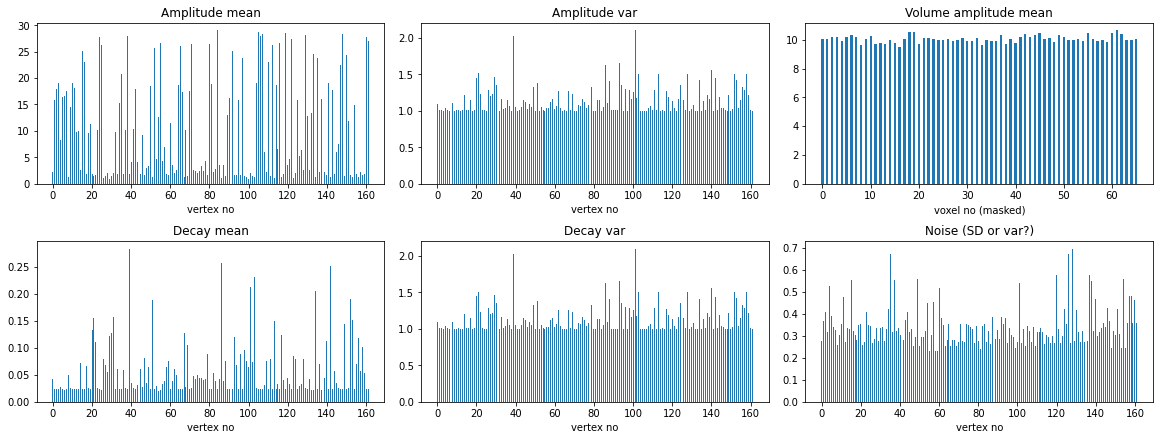

In [12]:
fig, axes = plt.subplots(2, 3, constrained_layout=True)
fig.set_size_inches(16,6)

axes[0,0].bar(np.arange(amp1_mean.size), amp1_mean, width=0.5)
axes[0,0].set_title('Amplitude mean')
axes[0,0].set_xlabel('vertex no')

axes[0,1].bar(np.arange(amp1_mean.size), amp1_var, width=0.5)
axes[0,1].set_title('Amplitude var')
axes[0,1].set_xlabel('vertex no')

axes[1,0].bar(np.arange(amp1_mean.size), r1_mean, width=0.5)
axes[1,0].set_title('Decay mean')
axes[1,0].set_xlabel('vertex no')

axes[1,1].bar(np.arange(amp1_mean.size), r1_var, width=0.5)
axes[1,1].set_title('Decay var')
axes[1,1].set_xlabel('vertex no')

axes[0,2].bar(np.arange(vol_amp1.size), vol_amp1, width=0.5)
axes[0,2].set_title('Volume amplitude mean')
axes[0,2].set_xlabel('voxel no (masked)')

axes[1,2].bar(np.arange(amp1_mean.size), noise_mean, width=0.5)
axes[1,2].set_title('Noise (SD or var?)')
axes[1,2].set_xlabel('vertex no')

plt.show()